In [1]:
import numpy as np
import ROOT

Welcome to JupyROOT 6.30/02


In [2]:
def fill_hist_with_sample(hist, sample):
    for val in sample:
        hist.Fill(val)

In [3]:
#-------------------------------------------
# simulate data/mc samples
#-------------------------------------------
# get monte carlo samples
mc_1 = np.random.exponential(300, size=10000)
mc_2 = np.random.exponential(150, size=5000)
mc_3 = np.random.normal(loc=300, scale=70, size=2000)

In [4]:
mc_1_hist = ROOT.TH1F("mc1", "mc1", 50, 0, 1000)
fill_hist_with_sample(mc_1_hist, mc_1)
mc_2_hist = ROOT.TH1F("mc2", "mc2", 50, 0, 1000)
fill_hist_with_sample(mc_2_hist, mc_2)
mc_3_hist = ROOT.TH1F("mc3", "mc3", 50, 0, 1000)
fill_hist_with_sample(mc_3_hist, mc_3)

In [5]:
mc_1_hist.SetFillColorAlpha(46, 0.35)
mc_2_hist.SetFillColorAlpha(30, 0.35)
mc_3_hist.SetFillColorAlpha(41, 0.35)


mc_stack = ROOT.THStack("mc", "")
mc_stack.Add(mc_1_hist)
mc_stack.Add(mc_2_hist)
mc_stack.Add(mc_3_hist)

In [6]:
data_hist = ROOT.TH1F("data", "data",
                      50, 0, 1000)

data_hist.Add(mc_1_hist, 3.5)
data_hist.Add(mc_2_hist, 0.5)
data_hist.Add(mc_3_hist, 1.6)

data_hist.SetMarkerStyle(8)
data_hist.SetMarkerSize(0.5)
data_hist.SetLineColor(1)
data_hist.SetMarkerColor(1)

mc_stack.SetMaximum(3000)

Info in <TCanvas::Print>: png file data-mc-pre.png has been created


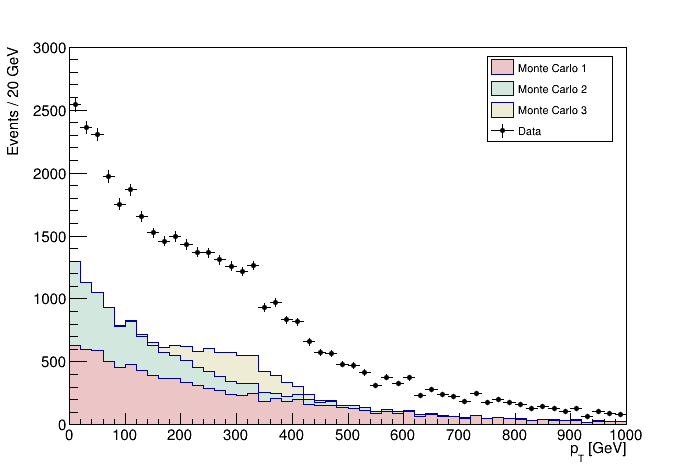

In [7]:
leg = ROOT.TLegend(0.7, 0.7, 0.88, 0.88)
leg.AddEntry(mc_1_hist, "Monte Carlo 1", "f")
leg.AddEntry(mc_2_hist, "Monte Carlo 2", "f")
leg.AddEntry(mc_3_hist, "Monte Carlo 3", "f")
leg.AddEntry(data_hist, "Data", "lep")


c1 = ROOT.TCanvas("c1", "c1")
mc_stack.Draw()
mc_stack.GetXaxis().SetTitle("p_{T} [GeV]")
mc_stack.GetYaxis().SetTitle("Events / 20 GeV")

data_hist.Draw("p, e0, same")
leg.Draw("same")
c1.Update()
c1.SaveAs("data-mc-pre.png")

In [8]:
#---------------------------------------------
# start RooFit setup
#---------------------------------------------
pT = ROOT.RooRealVar('pT', 'pT', 0, 1000) # define a variable for the stuff
mc1_roo_hist = ROOT.RooDataHist('mc1_roohist', 'mc1_roohist', pT, mc_1_hist)
mc2_roo_hist = ROOT.RooDataHist('mc2_roohist', 'mc2_roohist', pT, mc_2_hist)
mc3_roo_hist = ROOT.RooDataHist('mc3_roohist', 'mc3_roohist', pT, mc_3_hist)

data_roo_hist = ROOT.RooDataHist('data_roohist', 'data_roohist', pT, data_hist)

# set constants c1, c2, c3 so that
# (c1*mc1) +  (c2*mc2) +  (c3*mc3) = data
c1 = ROOT.RooRealVar('c1', 'c1', 1, 0, 1e10)
c2 = ROOT.RooRealVar('c2', 'c2', 1, 0, 1e10)
c3 = ROOT.RooRealVar('c3', 'c3', 1, 0, 1e10)

In [9]:
#---------------------------------------------
# make model
#---------------------------------------------
# make hist pdfs
mc1_roo_pdf = ROOT.RooHistPdf("mc1_pdf", "mc1_pdf", pT, mc1_roo_hist)
mc2_roo_pdf = ROOT.RooHistPdf("mc2_pdf", "mc2_pdf", pT, mc2_roo_hist)
mc3_roo_pdf = ROOT.RooHistPdf("mc3_pdf", "mc3_pdf", pT, mc3_roo_hist)

# make model
model = ROOT.RooAddPdf("model", "model",
                       ROOT.RooArgList(mc1_roo_pdf,
                                       mc2_roo_pdf,
                                       mc3_roo_pdf),
                       ROOT.RooArgList(c1, c2, c3))
# fit
model.fitTo(data_roo_hist)

# because we used PDFs, you gotta recover the real values
# by dividing the constants by nEvents in each MC sample
c1.setVal(c1.getValV() / 10000)
c2.setVal(c2.getValV() / 5000)
c3.setVal(c3.getValV() / 2000)

[#1] INFO:Minimization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#0] WARNING:InputArguments -- RooAbsPdf::fitTo(model): WARNING: a likelihood fit is requested of what appears to be weighted data.
       While the estimated values of the parameters will always be calculated taking the weights into account,
       there are multiple ways to estimate the errors of the parameters. You are advised to make an
       explicit choice for the error calculation:
           - Either provide SumW2Error(true), to calculate a sum-of-weights-corrected HESSE error matrix
             (error will be proportional to the number of events in MC).
           - Or provide SumW2Error(false), to return errors from original HESSE error matrix
             (which will be proportional to the sum of the weights, i.e., a dataset with <sum of weights> events).
           - Or provide AsymptoticError(true), to use the asymptotically correct expression
             (for det

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -116141.5595 Edm =       6103.042427 NCalls =     13
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : -116141.5595
  Edm           : 6103.042427
  Internal parameters:	[     -1.568843202     -1.568843202     -1.568843202]	
  Internal gradient  :	[     -6253888.141     -4513123.699     -294506.6803]	
  Internal covariance matrix:
[[  4.0174108e-10              0              0]
 [              0  4.2564396e-10              0]
 [              0              0   3.457668e-10]]]
Info in <Minuit2>: VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 1500
Info in <Minuit2>: VariableMetricBuilder    0 - FCN =      -116141.5595 Edm =       6103.042427 NCalls =     13
Info in <Minuit2>: VariableMetricBuilder    1 - FCN =      -119142.3689 Edm =       470.6659768 NCalls =     21
Info in <Minuit2>: VariableMe

In [10]:
#-----------------------------------------------------
# using corrections, plot new pdf
#-----------------------------------------------------
mc_1_hist_adjusted = mc_1_hist.Clone()
mc_1_hist_adjusted.Scale(c1.getValV())

mc_2_hist_adjusted = mc_2_hist.Clone()
mc_2_hist_adjusted.Scale(c2.getValV())

mc_3_hist_adjusted = mc_3_hist.Clone()
mc_3_hist_adjusted.Scale(c3.getValV())


mc_stack_adjusted = ROOT.THStack("mc_adjusted", "")
mc_stack_adjusted.Add(mc_1_hist_adjusted)
mc_stack_adjusted.Add(mc_2_hist_adjusted)
mc_stack_adjusted.Add(mc_3_hist_adjusted)


mc_stack_adjusted.SetMaximum(3000)

Info in <TCanvas::Print>: png file data-mc-post.png has been created


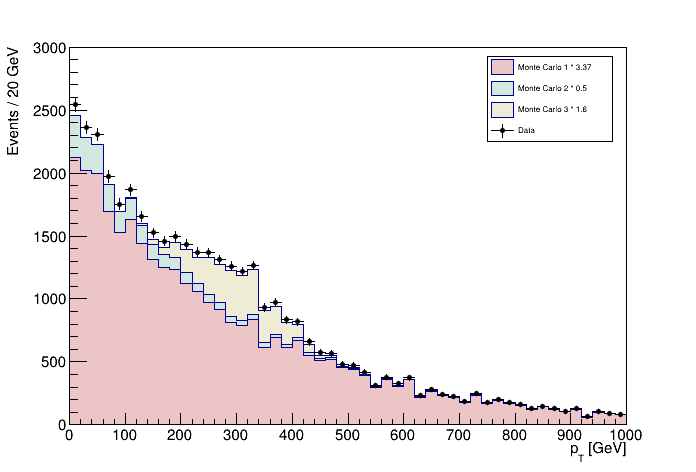

In [11]:
leg2 = ROOT.TLegend(0.7, 0.7, 0.88, 0.88)
leg2.AddEntry(mc_1_hist, "Monte Carlo 1 * %s" %round(c1.getValV(),2), "f")
leg2.AddEntry(mc_2_hist, "Monte Carlo 2 * %s" %round(c2.getValV(),2), "f")
leg2.AddEntry(mc_3_hist, "Monte Carlo 3 * %s" %round(c3.getValV(),2), "f")
leg2.AddEntry(data_hist, "Data", "lep")


c2 = ROOT.TCanvas("c2", "c2")
mc_stack_adjusted.Draw("hist")
mc_stack_adjusted.GetXaxis().SetTitle("p_{T} [GeV]")
mc_stack_adjusted.GetYaxis().SetTitle("Events / 20 GeV")

data_hist.Draw("p, e0, same")
leg2.Draw("same")
c2.Update()
c2.SaveAs("data-mc-post.png")